In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.models import resnet18
import time
from torchvision.transforms import ToPILImage
from PIL import Image
from IPython.display import display
import PIL

from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar
from torchvision.datasets.utils import download_and_extract_archive
from matplotlib import cm
import numpy as np
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
# ! pip install git+https://github.com/davidbau/baukit
# ! pip install torchinfo tqdm matplotlib
# ! unzip -q flat_spectrograms.zip
# ! unzip -q train_val_test.zip

In [2]:
from baukit import show
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_path = "/scratch/monaghan.ad/data/train_val_test1/train" # "data/spectrograms/train"
val_path = "/scratch/monaghan.ad/data/train_val_test1/val"
# test_path = "mnist_4440/test"
# train_set = ImageFolder(train_path)
# print("Number of images in the training set =", len(train_set))

cpu


In [3]:
from torchvision import transforms

class mapping_transform(object):
  def __init__(self, num_labels):
    self.num_labels = num_labels

  def __call__(self, labels):    
    # generate new random label
    # new_label = np.array([mapping[l] for l in labels])
    return mapping[labels]#new_label

mapping = {0: 0, 1: 0, 2: 1, 3: 3, 4: 0, 5: 2}

img_size = 256
train_set = torchvision.datasets.ImageFolder(
    train_path, 
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1), ToTensor(), transforms.Resize((img_size, img_size))
    ]),
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)

val_set = torchvision.datasets.ImageFolder(
    val_path, 
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1), ToTensor(), transforms.Resize((img_size, img_size))
    ]),
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)

train_set.targets = [mapping[t] for t in train_set.targets]
val_set.targets = [mapping[t] for t in val_set.targets]
train_set.classes = ["Background", "Fish", "Mn", "Vessel"]
val_set.classes = ["Background", "Fish", "Mn", "Vessel"]

In [4]:
img, label = train_set[1189]
len(train_set), len(val_set)

(56954, 8136)

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=400,
    shuffle=True,
    num_workers=6,
    # pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=400,
    shuffle=True,
    num_workers=6,
    # pin_memory=True,
)

In [6]:
# ## Some helper functions to view network parameters
from torchinfo import summary

def view_network_shapes(model, input_shape):
    print(summary(model, input_size=input_shape))

def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print("Model Summary\n")
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print("{}: {} elements".format(layer_tensor_name, torch.numel(tensor)))
    print(f"\nTotal Trainable Parameters: {total_parameters}!")

In [7]:
model = resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
model.fc = nn.Linear(512, 4, bias=True)
model = model.to(device)
view_network_shapes(model, img[None].shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 128, 128]         3,136
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         128
├─ReLU: 1-3                              [1, 64, 128, 128]         --
├─MaxPool2d: 1-4                         [1, 64, 64, 64]           --
├─Sequential: 1-5                        [1, 64, 64, 64]           --
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-3                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-6                    [1, 64, 64, 64]           --
│

In [8]:
@torch.inference_mode()  # understand what torch.inference_mode() or torch.no_grad() does
def evaluate_model(model, val_loader, loss_fn, return_confusion_matrix=False):
    model.eval()
    # Initiate a loss monitor
    val_loss = []
    correct_predictions = 0

    if return_confusion_matrix:
        confusion_matrix = torch.zeros(
            len(val_loader.dataset.classes), len(val_loader.dataset.classes)
        )

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        if return_confusion_matrix:
            for t, p in zip(labels.view(-1), predicted.argmax(dim=1).view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_acc = correct_predictions / len(val_loader.dataset)

    if return_confusion_matrix:
        return val_loss, val_acc, confusion_matrix
    else:
        return val_loss, val_acc

100%|██████████| 143/143 [00:59<00:00,  2.42it/s]


Text(0.5, 1.0, 'Distribution of Classes in Training Set')

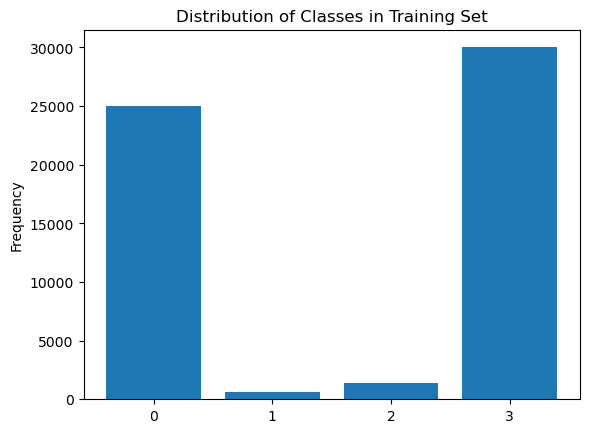

In [9]:
# plot the data distribution in the training set

from tqdm import tqdm
from matplotlib import pyplot as plt

counter = torch.zeros(len(train_set.classes))
for images, labels in tqdm(train_loader):
    for label in labels:
        counter[label] += 1

##########################################################
# **Exercise 4.2.1.2**
# TODO: Plot the distribution of classes in the training set as a bar plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
plt.bar(list(range(len(counter))), counter)
plt.xticks(range(4))
plt.ylabel("Frequency")
plt.title("Distribution of Classes in Training Set")

# raise NotImplementedError

##########################################################

In [10]:
model.load_state_dict(torch.load("weights5", map_location=device))
model.eval()
set_requires_grad(False, model)

In [11]:
as_image = ToPILImage()

def show_image(img, magnify = 3):
    as_image(img)
    display(as_image(img).resize((img.shape[0]*magnify, img.shape[1]*magnify)))

In [12]:
def rgb_heatmap(
    data,
    size=None,
    colormap="hot",
    amax=None,
    amin=None,
    mode="bicubic",
    symmetric=False,
):
    size = spec_size(size)
    mapping = getattr(cm, colormap)
    scaled = torch.nn.functional.interpolate(data[None, None], size=size, mode=mode)[
        0, 0
    ]
    if amax is None:
        amax = data.max()
    if amin is None:
        amin = data.min()
    if symmetric:
        amax = max(amax, -amin)
        amin = min(amin, -amax)
    normed = (scaled - amin) / (amax - amin + 1e-10)
    return PIL.Image.fromarray((255 * mapping(normed)).astype("uint8"))


def rgb_threshold(data, size=None, mode="bicubic", p=0.2):
    size = spec_size(size)
    scaled = torch.nn.functional.interpolate(data[None, None], size=size, mode=mode)[
        0, 0
    ]
    ordered = scaled.view(-1).sort()[0]
    threshold = ordered[int(len(ordered) * (1 - p))]
    result = numpy.tile((scaled > threshold)[:, :, None], (1, 1, 3))
    return PIL.Image.fromarray((255 * result).astype("uint8"))


def overlay(im1, im2, alpha=0.5):
    import numpy

    return PIL.Image.fromarray(
        (
            numpy.array(im1)[..., :3] * alpha + numpy.array(im2)[..., :3] * (1 - alpha)
        ).astype("uint8")
    )


def overlay_threshold(im1, im2, alpha=0.5):
    import numpy

    return PIL.Image.fromarray(
        (
            numpy.array(im1)[..., :3] * (1 - numpy.array(im2)[..., :3] / 255) * alpha
            + numpy.array(im2)[..., :3] * (numpy.array(im1)[..., :3] / 255)
        ).astype("uint8")
    )


def spec_size(size):
    if isinstance(size, int):
        dims = (size, size)
    if isinstance(size, torch.Tensor):
        size = size.shape[:2]
    if isinstance(size, PIL.Image.Image):
        size = (size.size[1], size.size[0])
    if size is None:
        size = (224, 224)
    return size


def resize_and_crop(im, d):
    if im.size[0] >= im.size[1]:
        im = im.resize((int(im.size[0] / im.size[1] * d), d))
        return im.crop(((im.size[0] - d) // 2, 0, (im.size[0] + d) // 2, d))
    else:
        im = im.resize((d, int(im.size[1] / im.size[9] * d)))
        return im.crop((0, (im.size[1] - d) // 2, d, (im.size[1] + d) // 2))

In [13]:
whale1 = resize_and_crop(PIL.Image.open("/scratch/monaghan.ad/cool/Cross_A_02_060114_200928_25666_4401.png"), 256)
whale2 = resize_and_crop(PIL.Image.open("/scratch/monaghan.ad/cool/Cross_A_02_060114_200928_25699_5267.png"), 256)
ship1 = resize_and_crop(PIL.Image.open("/scratch/monaghan.ad/cool/Saipan_A_01_100408_132115_24294_2726.png"), 256)
ship2 = resize_and_crop(PIL.Image.open("/scratch/monaghan.ad/cool/Tinian_A_04_140126_161130_24858_3494.png"), 256)
# show(whale1, whale2, ship1, ship2)

In [14]:
to_data = transforms.Compose([transforms.PILToTensor()])
whale1_data = to_data(whale1).float()
whale2_data = to_data(whale2).float()
ship1_data = to_data(ship1).float()
ship2_data = to_data(ship2).float()

In [15]:
out = model(whale1_data[:, None].to(device))
nn.Softmax()(out)

/home/monaghan.ad/ml/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[6.0134e-23, 0.0000e+00, 6.0256e-44, 1.0000e+00]])

In [16]:
out = model(whale2_data[:, None].to(device))
nn.Softmax()(out)

tensor([[4.0173e-30, 0.0000e+00, 0.0000e+00, 1.0000e+00]])

In [17]:
out = model(ship1_data[:, None].to(device))
nn.Softmax()(out)

tensor([[1.1797e-09, 0.0000e+00, 0.0000e+00, 1.0000e+00]])

In [18]:
out = model(ship2_data[:, None].to(device))
nn.Softmax()(out)

tensor([[6.3229e-17, 0.0000e+00, 0.0000e+00, 1.0000e+00]])

In [24]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


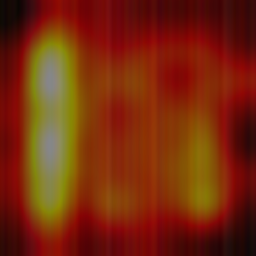
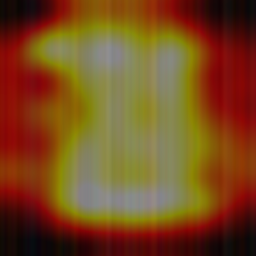
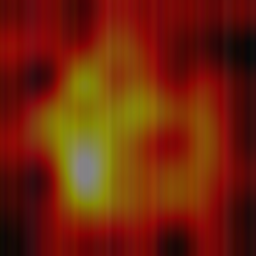
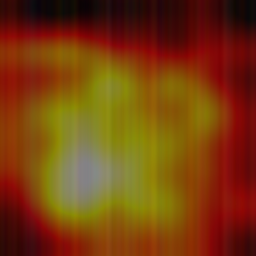
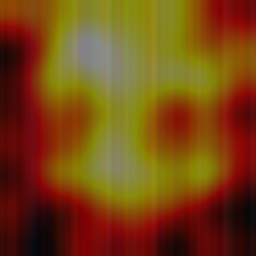
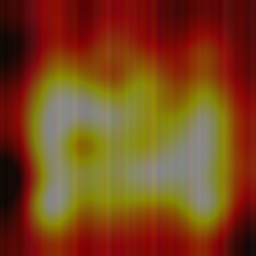
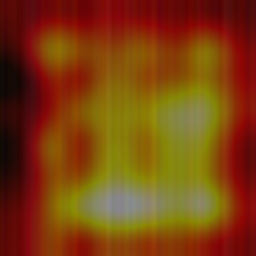
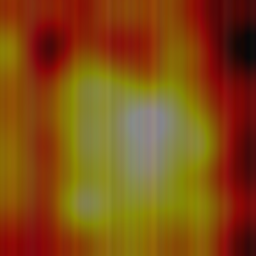
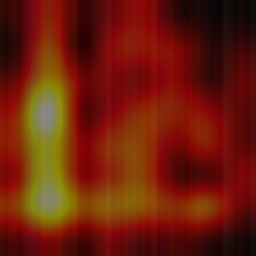
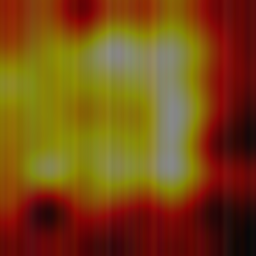
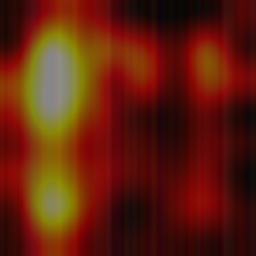
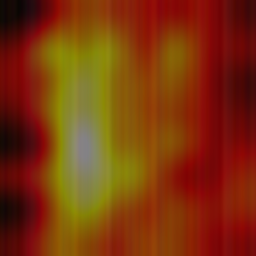

In [26]:
# TODO: find 12 filters of layer4.1.conv1 that are most activated by the image.

layer = "layer4.1.conv2"
# filter_num = 1
with Trace(model, layer) as tr:
    preds = model(ship1_data[None])
show(
    show.WRAP,
    [[f"neuron {filter_num}", overlay(whale1, rgb_heatmap(tr.output[0, filter_num], size=256))] 
     for filter_num in tr.output[0].flatten(start_dim=1, end_dim=2).max(dim=1)[0].topk(12)[1]],
)

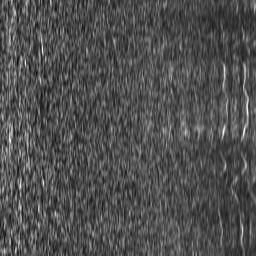

In [28]:
ship1

In [72]:
whale1_data.dtype

torch.float32

In [29]:
whale1_data.shape

torch.Size([1, 256, 256])

In [33]:
whale1.width, whale1.height

(256, 256)